# Metrics

Iniciando o processamento da série temporal...
Processando: savanna1990.tif...
Processando: savanna1995.tif...
Processando: savanna2000.tif...
Processando: savanna2005.tif...
Processando: savanna2010.tif...
Processando: savanna2015.tif...
Processando: savanna2020.tif...

Gerando o gráfico...


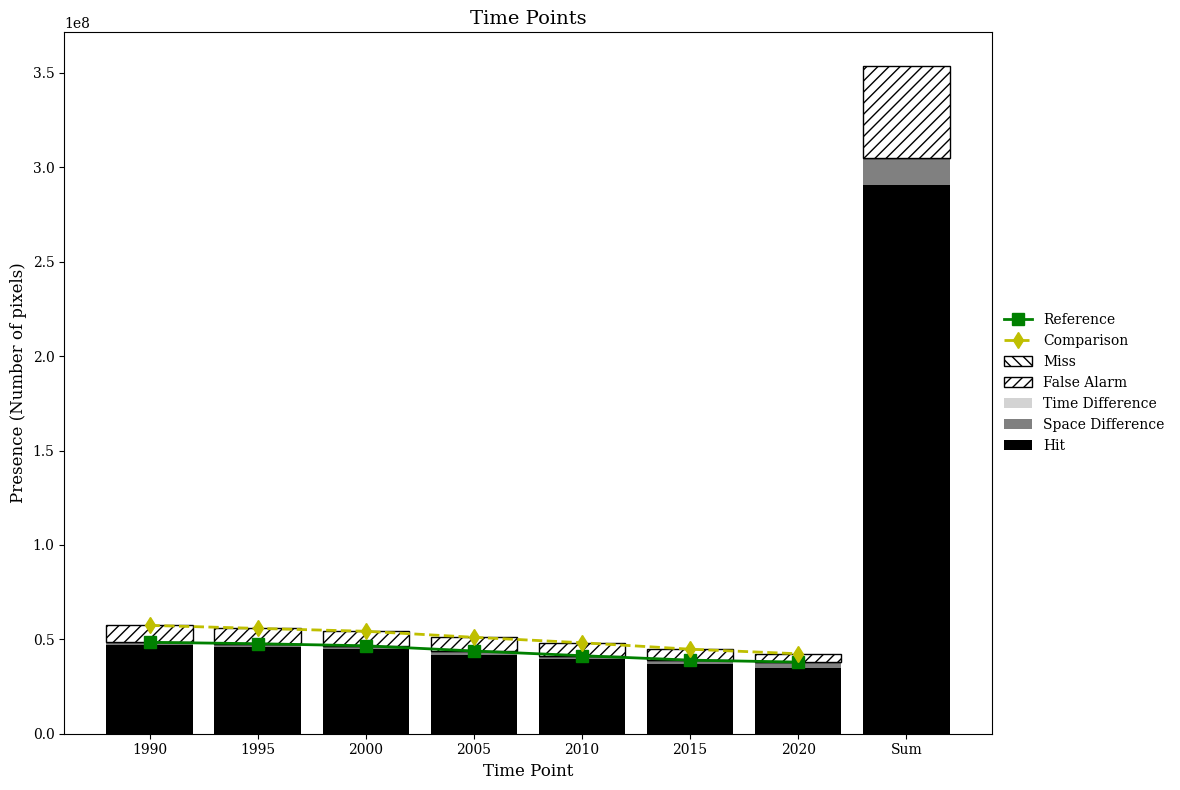


Processamento concluído. Gráfico salvo como: presence_agreement_savanna_final_ordered.png


In [1]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# =============================================================================
# 1. DEFINIÇÃO DOS PARÂMETROS
# =============================================================================

# Input raster maps:
path_series_x = r"C:\Users\AntFonseca\github\compare-time-series\input\collection6"
path_series_y = r"C:\Users\AntFonseca\github\compare-time-series\input\collection8"
time_points = [1990, 1995, 2000, 2005, 2010, 2015, 2020]
class_name = "savanna"
# path_series_x = r"C:\Users\AntFonseca\github\compare-time-series\input\toydata\x"
# path_series_y = r"C:\Users\AntFonseca\github\compare-time-series\input\toydata\y"
# time_points = [0, 1, 2]
# class_name = "toydata"

# Valor que representa 'NoData' nos arquivos raster
nodata_value = 255

# =============================================================================
# 2. FUNÇÃO PARA CÁLCULO DAS MÉTRICAS DE PRESENÇA
# (Versão já corrigida da etapa anterior)
# =============================================================================

def calculate_presence_metrics(file_x, file_y):
    """
    Calcula as métricas de concordância de presença para um único ponto no tempo.
    """
    with rasterio.open(file_x) as src_x, rasterio.open(file_y) as src_y:
        array_x = src_x.read(1)
        array_y = src_y.read(1)
        valid_mask = (array_x != nodata_value) & (array_y != nodata_value)
        presence_x = array_x[valid_mask]
        presence_y = array_y[valid_mask]

        hits = np.sum(np.minimum(presence_x, presence_y))
        total_x = np.sum(presence_x)
        total_y = np.sum(presence_y)

        # --- CORREÇÃO DE OVERFLOW ---
        # Converte os totais para um tipo de inteiro com sinal (int64) antes da subtração
        # para evitar o erro de 'overflow'.
        hits = hits.astype(np.int64)
        total_x = total_x.astype(np.int64)
        total_y = total_y.astype(np.int64)
        # --- FIM DA CORREÇÃO ---

        space_difference = np.minimum(total_x, total_y) - hits
        misses = np.maximum(0, total_x - total_y)
        false_alarms = np.maximum(0, total_y - total_x)

        return {
            "Hit": hits, "Miss": misses, "False Alarm": false_alarms,
            "Space Difference": space_difference, "Total X": total_x, "Total Y": total_y
        }

# =============================================================================
# 3. PROCESSAMENTO DA SÉRIE TEMPORAL
# =============================================================================

results_by_time = {}
print("Iniciando o processamento da série temporal...")
for year in time_points:
    # Monta o nome do arquivo com base no padrão padronizado: {classe}{ano}.tif
    file_name = f"{class_name}{year}.tif"
    file_x = os.path.join(path_series_x, file_name)
    file_y = os.path.join(path_series_y, file_name)

    # Verifica se ambos os arquivos existem antes de processar
    if os.path.exists(file_x) and os.path.exists(file_y):
        print(f"Processando: {file_name}...")
        results_by_time[year] = calculate_presence_metrics(file_x, file_y)
    else:
        print(f"Aviso: Arquivo '{file_name}' não encontrado em ambas as pastas. Pulando.")

# =============================================================================
# 4. CÁLCULO DOS TOTAIS (SUM) - LÓGICA FINAL CORRIGIDA
# =============================================================================

sum_results = {
    "Hit": 0, "Space Difference": 0, "Total X": 0, "Total Y": 0
}

# Soma os componentes de Hit, Space Difference e Totais de todos os anos
for year in results_by_time:
    sum_results["Hit"] += results_by_time[year]["Hit"]
    sum_results["Space Difference"] += results_by_time[year]["Space Difference"]
    sum_results["Total X"] += results_by_time[year]["Total X"]
    sum_results["Total Y"] += results_by_time[year]["Total Y"]

# Calcula Time Difference (Equação 10)
sum_results["Time Difference"] = (
    np.minimum(sum_results["Total X"], sum_results["Total Y"])
    - sum_results["Hit"]
    - sum_results["Space Difference"]
)

# --- CORREÇÃO FINAL APLICADA AQUI ---
# Calcula Miss e False Alarm para a barra "Sum" com base nos totais gerais.
# Um desses valores será sempre zero. (Equações 11 e 12)

sum_results["Miss"] = np.maximum(0, sum_results["Total X"] - sum_results["Total Y"])
sum_results["False Alarm"] = np.maximum(0, sum_results["Total Y"] - sum_results["Total X"])
# --- FIM DA CORREÇÃO FINAL ---

# =============================================================================
# 5. GERAÇÃO DO GRÁFICO
# =============================================================================
print("\nGerando o gráfico...")

mpl.rcParams['font.family'] = 'serif'

labels = [str(tp) for tp in time_points] + ["Sum"]

# Dados para as barras e linhas
hits = [results_by_time.get(tp, {}).get("Hit", 0) for tp in time_points] + [sum_results["Hit"]]
space_diff = [results_by_time.get(tp, {}).get("Space Difference", 0) for tp in time_points] + [sum_results["Space Difference"]]
time_diff = [0] * len(time_points) + [sum_results["Time Difference"]]
misses = [results_by_time.get(tp, {}).get("Miss", 0) for tp in time_points] + [sum_results["Miss"]]
false_alarms = [results_by_time.get(tp, {}).get("False Alarm", 0) for tp in time_points] + [sum_results["False Alarm"]]

reference_line = [results_by_time.get(tp, {}).get("Total X", 0) for tp in time_points]
comparison_line = [results_by_time.get(tp, {}).get("Total Y", 0) for tp in time_points]

fig, ax = plt.subplots(figsize=(14, 8))

# --- Plotagem dos elementos ---
bottom = np.zeros(len(labels))
ax.bar(labels, hits, label='Hit', color='black', bottom=bottom); bottom += np.array(hits)
ax.bar(labels, space_diff, label='Space Difference', color='grey', bottom=bottom); bottom += np.array(space_diff)
ax.bar(labels, time_diff, label='Time Difference', color='lightgray', bottom=bottom); bottom += np.array(time_diff)
ax.bar(labels, misses, label='Miss', color='white', edgecolor='black', hatch='\\\\\\', bottom=bottom); bottom += np.array(misses)
ax.bar(labels, false_alarms, label='False Alarm', color='white', edgecolor='black', hatch='///', bottom=bottom)

ax.plot(labels[:-1], reference_line, 's-g', label='Reference', linewidth=2, markersize=8)
ax.plot(labels[:-1], comparison_line, 'd--y', label='Comparison', linewidth=2, markersize=8)


# --- LÓGICA PARA ORDENAR A LEGENDA ---
# 1. Pega todos os handles e labels que foram plotados
handles, labels = ax.get_legend_handles_labels()

# 2. Define a ordem desejada para os labels (com a correção)
order = ["Reference", "Comparison", "Miss", "False Alarm", "Time Difference", "Space Difference", "Hit"]

# 3. Cria um dicionário para mapear labels aos seus handles
legend_dict = dict(zip(labels, handles))

# 4. Reorganiza os handles e labels de acordo com a lista 'order'
ordered_handles = [legend_dict[label] for label in order]
ordered_labels = order

# 5. Cria a legenda com os itens já ordenados
ax.legend(ordered_handles, ordered_labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
# --- FIM DA LÓGICA DE ORDENAÇÃO ---

ax.set_title('Time Points', fontsize=14)
ax.set_xlabel('Time Point', fontsize=12)
ax.set_ylabel('Presence (Number of pixels)', fontsize=12)
plt.tight_layout(rect=[0, 0, 0.85, 1])

output_filename = f'presence_agreement_{class_name}_final_ordered.png'
plt.savefig(output_filename, dpi=300)

plt.show()

print(f"\nProcessamento concluído. Gráfico salvo como: {output_filename}")

✅ Iniciando a Célula de Cálculo de Ganhos e Perdas.
Calculando métricas de mudança para cada intervalo...
Processando intervalo: 1990-1995...
Lendo do disco: savanna1995.tif...
Lendo do disco: savanna1990.tif...
Processando intervalo: 1995-2000...
Lendo do disco: savanna2000.tif...
Processando intervalo: 2000-2005...
Lendo do disco: savanna2005.tif...
Processando intervalo: 2005-2010...
Lendo do disco: savanna2010.tif...
Processando intervalo: 2010-2015...
Lendo do disco: savanna2015.tif...
Processando intervalo: 2015-2020...
Lendo do disco: savanna2020.tif...
Calculando métricas para a Extensão Temporal...

Gerando o gráfico de Ganhos e Perdas...


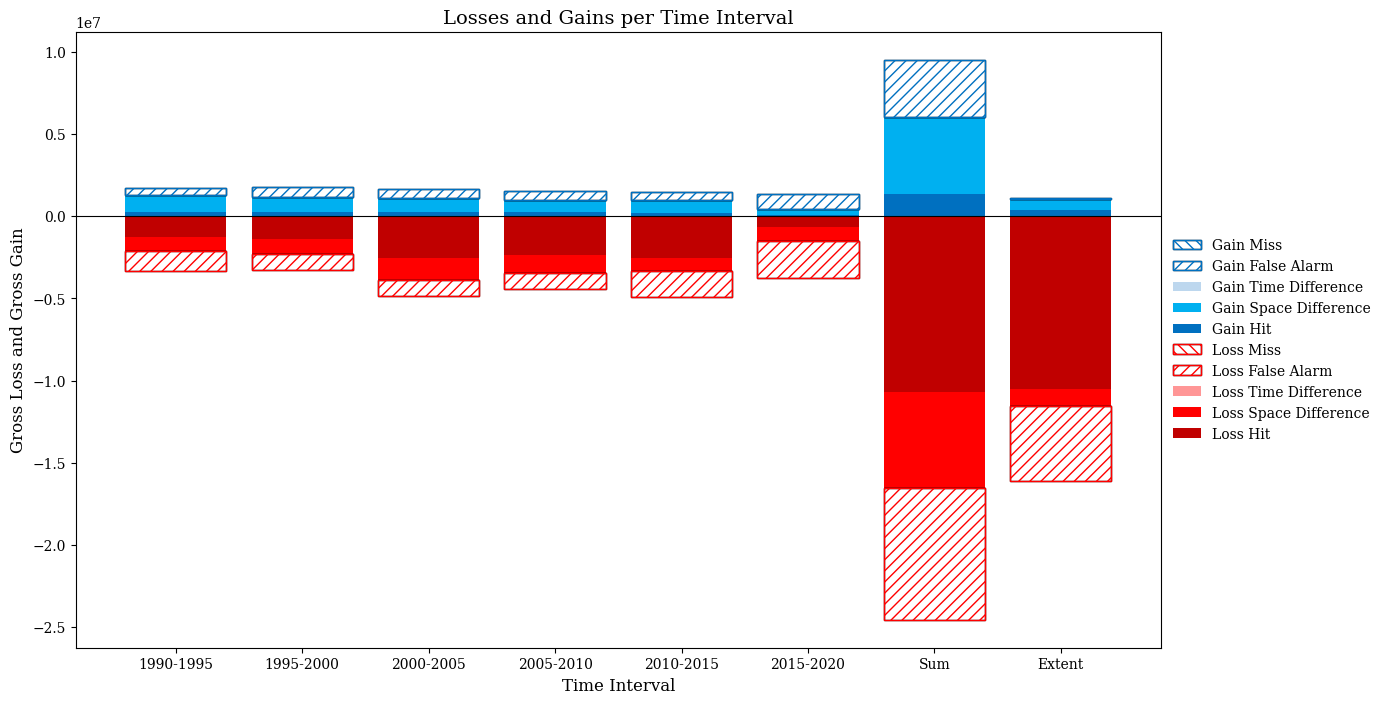


Processamento concluído. Gráfico salvo como: change_agreement_savanna.png


In [2]:
# =============================================================================
# NOVA CÉLULA: Ganhos e Perdas Brutos por Intervalo de Tempo (Versão Final com Extent)
# =============================================================================
print("✅ Iniciando a Célula de Cálculo de Ganhos e Perdas.")

# Dicionário para armazenar os arrays de raster e evitar releituras nesta célula
raster_arrays = {}

def get_raster_array(year):
    """
    Lê um par de arquivos raster (x e y) para um dado ano ou o retorna 
    do cache se já tiver sido lido anteriormente nesta célula.
    """
    if year in raster_arrays:
        return raster_arrays[year]
    
    file_name = f"{class_name}{year}.tif"
    path_x = os.path.join(path_series_x, file_name)
    path_y = os.path.join(path_series_y, file_name)

    if not os.path.exists(path_x) or not os.path.exists(path_y):
        print(f"Aviso: Arquivo '{file_name}' não encontrado para o ano {year}.")
        return None, None

    print(f"Lendo do disco: {file_name}...")
    with rasterio.open(path_x) as src_x, rasterio.open(path_y) as src_y:
        array_x = src_x.read(1)
        array_y = src_y.read(1)
        # Armazena os arrays no cache para uso futuro nesta célula
        raster_arrays[year] = (array_x, array_y)
        return array_x, array_y

# =============================================================================
# 1. FUNÇÕES DE CÁLCULO DE MÉTRICAS
# =============================================================================

def calculate_change_metrics(year_t, year_t_minus_1):
    array_x_t, array_y_t = get_raster_array(year_t)
    array_x_t_minus_1, array_y_t_minus_1 = get_raster_array(year_t_minus_1)
    if array_x_t is None or array_x_t_minus_1 is None: return None
    valid_mask = (array_x_t != nodata_value) & (array_y_t != nodata_value) & \
                 (array_x_t_minus_1 != nodata_value) & (array_y_t_minus_1 != nodata_value)
    px_t, py_t = array_x_t[valid_mask].astype(np.int64), array_y_t[valid_mask].astype(np.int64)
    px_t_minus_1, py_t_minus_1 = array_x_t_minus_1[valid_mask].astype(np.int64), array_y_t_minus_1[valid_mask].astype(np.int64)
    gain_x, gain_y = np.maximum(0, px_t - px_t_minus_1), np.maximum(0, py_t - py_t_minus_1)
    gain_total_x, gain_total_y = np.sum(gain_x), np.sum(gain_y)
    gain_hit = np.sum(np.minimum(gain_x, gain_y))
    gain_space_diff = np.minimum(gain_total_x, gain_total_y) - gain_hit
    gain_miss = np.maximum(0, gain_total_x - gain_total_y)
    gain_false_alarm = np.maximum(0, gain_total_y - gain_total_x)
    loss_x, loss_y = np.minimum(0, px_t - px_t_minus_1), np.minimum(0, py_t - py_t_minus_1)
    loss_total_x, loss_total_y = np.sum(loss_x), np.sum(loss_y)
    loss_hit = np.sum(np.maximum(loss_x, loss_y))
    loss_space_diff = np.maximum(loss_total_x, loss_total_y) - loss_hit
    loss_miss = np.minimum(0, loss_total_x - loss_total_y)
    loss_false_alarm = np.minimum(0, loss_total_y - loss_total_x)
    return {"Gain Hit": gain_hit, "Gain Miss": gain_miss, "Gain False Alarm": gain_false_alarm, "Gain Space Difference": gain_space_diff,
            "Loss Hit": loss_hit, "Loss Miss": loss_miss, "Loss False Alarm": loss_false_alarm, "Loss Space Difference": loss_space_diff,
            "Gain Total X": gain_total_x, "Gain Total Y": gain_total_y, "Loss Total X": loss_total_x, "Loss Total Y": loss_total_y}

def calculate_extent_metrics(time_points_list):
    """
    Calcula as métricas de ganho e perda para a extensão temporal total.
    """
    start_year, end_year = time_points_list[0], time_points_list[-1]
    array_x_start, array_y_start = get_raster_array(start_year)
    array_x_end, array_y_end = get_raster_array(end_year)
    if array_x_start is None or array_x_end is None: return None
    valid_mask = (array_x_start != nodata_value) & (array_y_start != nodata_value) & \
                 (array_x_end != nodata_value) & (array_y_end != nodata_value)
    px_start, py_start = array_x_start[valid_mask].astype(np.int64), array_y_start[valid_mask].astype(np.int64)
    px_end, py_end = array_x_end[valid_mask].astype(np.int64), array_y_end[valid_mask].astype(np.int64)
    gain_x, gain_y = np.maximum(0, px_end - px_start), np.maximum(0, py_end - py_start)
    gain_total_x, gain_total_y = np.sum(gain_x), np.sum(gain_y)
    gain_hit = np.sum(np.minimum(gain_x, gain_y))
    gain_space_diff = np.minimum(gain_total_x, gain_total_y) - gain_hit
    gain_miss = np.maximum(0, gain_total_x - gain_total_y)
    gain_false_alarm = np.maximum(0, gain_total_y - gain_total_x)
    loss_x, loss_y = np.minimum(0, px_end - px_start), np.minimum(0, py_end - py_start)
    loss_total_x, loss_total_y = np.sum(loss_x), np.sum(loss_y)
    loss_hit = np.sum(np.maximum(loss_x, loss_y))
    loss_space_diff = np.maximum(loss_total_x, loss_total_y) - loss_hit
    loss_miss = np.minimum(0, loss_total_x - loss_total_y)
    loss_false_alarm = np.minimum(0, loss_total_y - loss_total_x)
    return {"Gain Hit": gain_hit, "Gain Miss": gain_miss, "Gain False Alarm": gain_false_alarm, "Gain Space Difference": gain_space_diff,
            "Loss Hit": loss_hit, "Loss Miss": loss_miss, "Loss False Alarm": loss_false_alarm, "Loss Space Difference": loss_space_diff}

# =============================================================================
# 2. PROCESSAMENTO DOS INTERVALOS E DO EXTENT
# =============================================================================
change_results_by_interval = {}
time_intervals = []
print("Calculando métricas de mudança para cada intervalo...")
for i in range(1, len(time_points)):
    year_t, year_t_minus_1 = time_points[i], time_points[i-1]
    interval_label = f"{year_t_minus_1}-{year_t}"
    time_intervals.append(interval_label)
    print(f"Processando intervalo: {interval_label}...")
    change_results_by_interval[interval_label] = calculate_change_metrics(year_t, year_t_minus_1)

print("Calculando métricas para a Extensão Temporal...")
extent_results = calculate_extent_metrics(time_points)

# =============================================================================
# 3. CÁLCULO DOS TOTAIS (SUM) PARA MUDANÇA
# =============================================================================
sum_change_results = { "Gain Hit": 0, "Gain Space Difference": 0, "Gain Total X": 0, "Gain Total Y": 0, "Gain Time Difference": 0, "Loss Hit": 0, "Loss Space Difference": 0, "Loss Total X": 0, "Loss Total Y": 0, "Loss Time Difference": 0, }
for interval in time_intervals:
    results = change_results_by_interval[interval]
    if results:
        for key in ["Gain Hit", "Gain Space Difference", "Gain Total X", "Gain Total Y", "Loss Hit", "Loss Space Difference", "Loss Total X", "Loss Total Y"]:
            sum_change_results[key] += results[key]
sum_change_results["Gain Time Difference"] = np.minimum(sum_change_results["Gain Total X"], sum_change_results["Gain Total Y"]) - sum_change_results["Gain Hit"] - sum_change_results["Gain Space Difference"]
sum_change_results["Gain Miss"] = np.maximum(0, sum_change_results["Gain Total X"] - sum_change_results["Gain Total Y"])
sum_change_results["Gain False Alarm"] = np.maximum(0, sum_change_results["Gain Total Y"] - sum_change_results["Gain Total X"])
sum_change_results["Loss Time Difference"] = np.maximum(sum_change_results["Loss Total X"], sum_change_results["Loss Total Y"]) - sum_change_results["Loss Hit"] - sum_change_results["Loss Space Difference"]
sum_change_results["Loss Miss"] = np.minimum(0, sum_change_results["Loss Total X"] - sum_change_results["Loss Total Y"])
sum_change_results["Loss False Alarm"] = np.minimum(0, sum_change_results["Loss Total Y"] - sum_change_results["Loss Total X"])

# Importa a biblioteca de patches do Matplotlib, necessária para criar a legenda customizada
import matplotlib.patches as mpatches

# =============================================================================
# 4. GERAÇÃO DO GRÁFICO DE GANHOS E PERDAS (LEGENDA CORRIGIDA)
# =============================================================================
print("\nGerando o gráfico de Ganhos e Perdas...")

labels = time_intervals + ["Sum", "Extent"]

gain_colors = {
    'Hit': '#0070C0',
    'Space Difference': '#00B0F0',
    'Time Difference': '#BDD7EE',
    'Miss': 'white',
    'False Alarm': 'white'
}
loss_colors = {
    'Hit': '#C00000',
    'Space Difference': '#FF0000',
    'Time Difference': '#FF9696',
    'Miss': 'white',
    'False Alarm': 'white'
}

gain_hatch_color = '#0070C0'
loss_hatch_color = '#FF0000'

fig, ax = plt.subplots(figsize=(14, 8))
mpl.rcParams['font.family'] = 'serif'

# --- Plotagem dos Ganhos (Lógica inalterada) ---
bottom_gain = np.zeros(len(labels))
for comp in ["Hit", "Space Difference", "Time Difference", "Miss", "False Alarm"]:
    data = [change_results_by_interval.get(interval, {}).get(f"Gain {comp}", 0) for interval in time_intervals]
    data.append(sum_change_results.get(f"Gain {comp}", 0))
    data.append(extent_results.get(f"Gain {comp}", 0))
    if comp == "Time Difference": data[-1] = 0
    if comp in ["Miss", "False Alarm"]:
        hatch = '///' if comp == 'False Alarm' else '\\\\\\'
        ax.bar(labels, data, label=f'Gain {comp}', color='white', bottom=bottom_gain, edgecolor='black')
        ax.bar(labels, data, color='none', bottom=bottom_gain, edgecolor=gain_hatch_color, hatch=hatch)
    else:
        ax.bar(labels, data, label=f'Gain {comp}', color=gain_colors[comp], bottom=bottom_gain, edgecolor='none')
    bottom_gain += np.array(data)

# --- Plotagem das Perdas (Lógica inalterada) ---
bottom_loss = np.zeros(len(labels))
for comp in ["Hit", "Space Difference", "Time Difference", "Miss", "False Alarm"]:
    data = [change_results_by_interval.get(interval, {}).get(f"Loss {comp}", 0) for interval in time_intervals]
    data.append(sum_change_results.get(f"Loss {comp}", 0))
    data.append(extent_results.get(f"Loss {comp}", 0))
    if comp == "Time Difference": data[-1] = 0
    if comp in ["Miss", "False Alarm"]:
        hatch = '///' if comp == 'False Alarm' else '\\\\\\'
        ax.bar(labels, data, label=f'Loss {comp}', color='white', bottom=bottom_loss, edgecolor='black')
        ax.bar(labels, data, color='none', bottom=bottom_loss, edgecolor=loss_hatch_color, hatch=hatch)
    else:
        ax.bar(labels, data, label=f'Loss {comp}', color=loss_colors[comp], bottom=bottom_loss, edgecolor='none')
    bottom_loss += np.array(data)

# --- Configurações Finais do Gráfico ---
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Losses and Gains per Time Interval', fontsize=14)
ax.set_xlabel('Time Interval', fontsize=12)
ax.set_ylabel('Gross Loss and Gross Gain', fontsize=12)

# --- LÓGICA PARA ORDENAR A LEGENDA (COM CORREÇÃO DOS HANDLES) ---
handles, labels_list = ax.get_legend_handles_labels()
legend_dict = dict(zip(labels_list, handles))

# --- CRIAÇÃO DOS HANDLES PERSONALIZADOS PARA A LEGENDA ---
# Para cada item hachurado, criamos uma legenda que é uma tupla de dois patches:
# a base branca/borda preta + a hachura colorida/fundo transparente.
legend_dict['Gain Miss'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='\\\\\\')
)
legend_dict['Gain False Alarm'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='///')
)
legend_dict['Loss Miss'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='\\\\\\')
)
legend_dict['Loss False Alarm'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='///')
)

order = [
    'Gain Miss', 'Gain False Alarm', 'Gain Time Difference', 'Gain Space Difference', 'Gain Hit',
    'Loss Miss', 'Loss False Alarm', 'Loss Time Difference', 'Loss Space Difference', 'Loss Hit'
]
ordered_handles = [legend_dict[label] for label in order]
ordered_labels = order

ax.legend(
    handles=ordered_handles,
    labels=ordered_labels,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False
)

output_filename = f'change_agreement_{class_name}.png'
plt.savefig(
    output_filename,
    dpi=300
)

plt.show()

print(f"\nProcessamento concluído. Gráfico salvo como: {output_filename}")

✅ Iniciando a Célula de Gráfico de Mudança Líquida (Baseado nas Equações).
Calculando os componentes de Mudança Líquida para cada intervalo...
Calculando os componentes de Mudança Líquida para a Extensão...
Calculando os componentes de Mudança Líquida para a Soma...

Gerando o gráfico de Mudança Líquida...


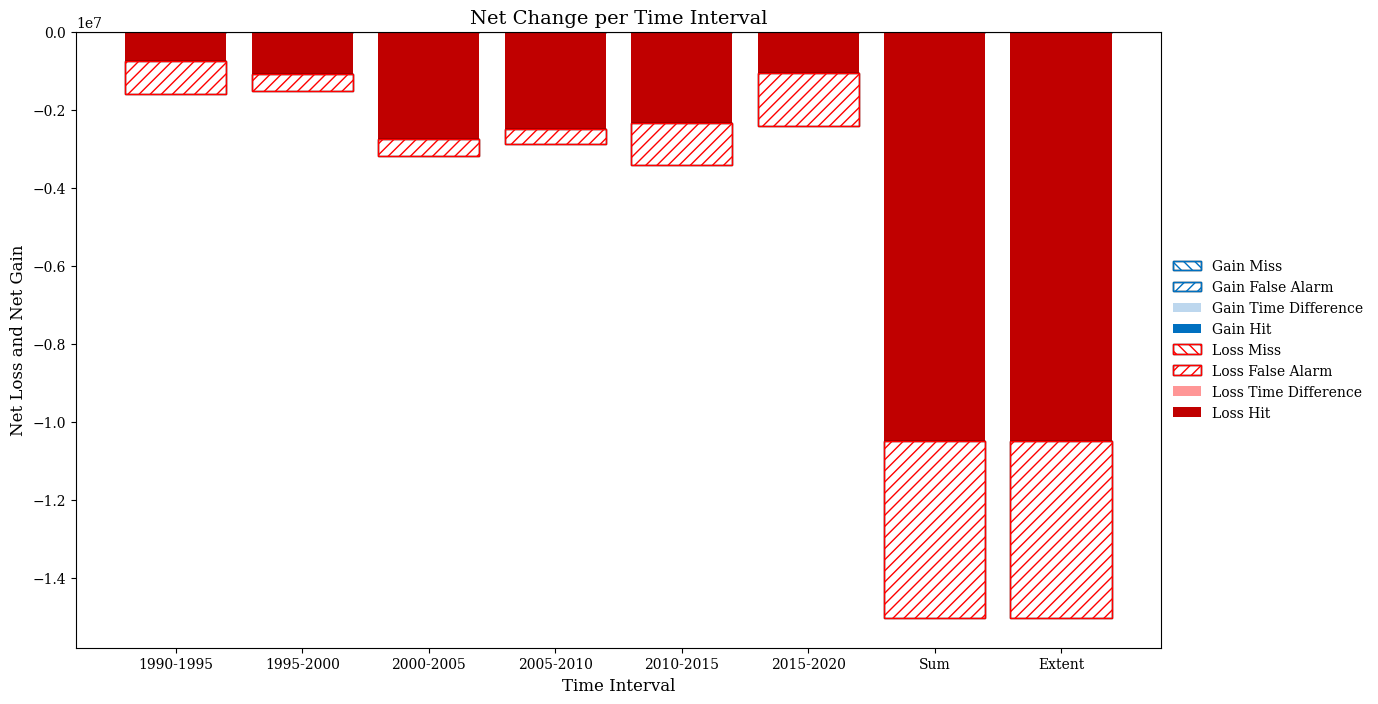


Processamento concluído. Gráfico de Mudança Líquida salvo como: net_change_agreement_savanna.png


In [3]:
# =============================================================================
# NOVA CÉLULA: Gráfico de Mudança Líquida (Net Change) - Versão Final
# =============================================================================
print("✅ Iniciando a Célula de Gráfico de Mudança Líquida (Baseado nas Equações).")

# Importa a biblioteca de patches, caso a célula seja executada de forma independente
import matplotlib.patches as mpatches

# =============================================================================
# 1. FUNÇÃO PARA CÁLCULO DOS COMPONENTES DE MUDANÇA LÍQUIDA
# =============================================================================

def calculate_net_change_components(gross_results):
    """
    Calcula os componentes de Net Change a partir dos resultados de Gross Change,
    seguindo as equações 41-48 do artigo.
    """
    if not gross_results:
        return None

    # --- Passo 1: Calcular Quantity Gain e Quantity Loss (Eqs. 41-44) ---
    Ght, Gut, Gmt, Gft = gross_results["Gain Hit"], gross_results["Gain Space Difference"], gross_results["Gain Miss"], gross_results["Gain False Alarm"]
    Lht, Lut, Lmt, Lft = gross_results["Loss Hit"], gross_results["Loss Space Difference"], gross_results["Loss Miss"], gross_results["Loss False Alarm"]

    QGxt = np.maximum(0, Ght + Gut + Gmt + Lht + Lut + Lmt)
    QGyt = np.maximum(0, Ght + Gut + Gft + Lht + Lut + Lft)
    QLxt = np.minimum(0, Ght + Gut + Gmt + Lht + Lut + Lmt)
    QLyt = np.minimum(0, Ght + Gut + Gft + Lht + Lut + Lft)

    # --- Passo 2: Calcular os componentes de Net Change ---
    net_gain_hit = np.minimum(QGxt, QGyt)
    net_gain_miss = np.maximum(0, QGxt - QGyt)
    net_gain_false_alarm = np.maximum(0, QGyt - QGxt)
    net_loss_hit = np.maximum(QLxt, QLyt)
    net_loss_miss = np.minimum(0, QLxt - QLyt)
    net_loss_false_alarm = np.minimum(0, QLyt - QLxt)
    
    return {
        "Gain Hit": net_gain_hit, "Gain Miss": net_gain_miss, "Gain False Alarm": net_gain_false_alarm,
        "Loss Hit": net_loss_hit, "Loss Miss": net_loss_miss, "Loss False Alarm": net_loss_false_alarm,
        "QG_Total_X": QGxt, "QG_Total_Y": QGyt, "QL_Total_X": QLxt, "QL_Total_Y": QLyt
    }

# =============================================================================
# 2. PROCESSAMENTO PARA OBTER OS COMPONENTES DE NET CHANGE
# =============================================================================
net_change_by_interval = {}
print("Calculando os componentes de Mudança Líquida para cada intervalo...")
for interval_label, gross_results in change_results_by_interval.items():
    net_change_by_interval[interval_label] = calculate_net_change_components(gross_results)

print("Calculando os componentes de Mudança Líquida para a Extensão...")
net_extent_results = calculate_net_change_components(extent_results)

# =============================================================================
# 3. CÁLCULO DOS TOTAIS (SUM) PARA NET CHANGE - LÓGICA CORRIGIDA
# =============================================================================
print("Calculando os componentes de Mudança Líquida para a Soma...")
sum_net_results = { 
    "QG_Total_X": 0, "QG_Total_Y": 0, "QL_Total_X": 0, "QL_Total_Y": 0,
    "Gain Hit": 0, "Loss Hit": 0 # Inicializa os hits da soma
}
# Primeiro, acumula os totais de QG, QL e os HITS de cada intervalo
for interval, results in net_change_by_interval.items():
    if results:
        sum_net_results["QG_Total_X"] += results["QG_Total_X"]
        sum_net_results["QG_Total_Y"] += results["QG_Total_Y"]
        sum_net_results["QL_Total_X"] += results["QL_Total_X"]
        sum_net_results["QL_Total_Y"] += results["QL_Total_Y"]
        # Acumula os hits dos intervalos para obter o Hit da barra SUM
        sum_net_results["Gain Hit"] += results["Gain Hit"]
        sum_net_results["Loss Hit"] += results["Loss Hit"]

# Agora, calcula os componentes finais para a barra SUM
# Miss e False Alarm são calculados a partir dos totais de quantidade
sum_net_results["Gain Miss"] = np.maximum(0, sum_net_results["QG_Total_X"] - sum_net_results["QG_Total_Y"])
sum_net_results["Gain False Alarm"] = np.maximum(0, sum_net_results["QG_Total_Y"] - sum_net_results["QG_Total_X"])
sum_net_results["Loss Miss"] = np.minimum(0, sum_net_results["QL_Total_X"] - sum_net_results["QL_Total_Y"])
sum_net_results["Loss False Alarm"] = np.minimum(0, sum_net_results["QL_Total_Y"] - sum_net_results["QL_Total_X"])

# Time Difference é o que sobra da concordância de quantidade depois de subtrair a soma dos hits
sum_net_results["Gain Time Difference"] = np.minimum(sum_net_results["QG_Total_X"], sum_net_results["QG_Total_Y"]) - sum_net_results["Gain Hit"]
sum_net_results["Loss Time Difference"] = np.maximum(sum_net_results["QL_Total_X"], sum_net_results["QL_Total_Y"]) - sum_net_results["Loss Hit"]

# =============================================================================
# 4. GERAÇÃO DO GRÁFICO DE MUDANÇA LÍQUIDA
# =============================================================================
print("\nGerando o gráfico de Mudança Líquida...")
labels = time_intervals + ["Sum", "Extent"]
gain_colors = {'Hit': '#0070C0', 'Time Difference': '#BDD7EE', 'Miss': 'white', 'False Alarm': 'white'}
loss_colors = {'Hit': '#C00000', 'Time Difference': '#FF9696', 'Miss': 'white', 'False Alarm': 'white'}
gain_hatch_color, loss_hatch_color = '#0070C0', '#FF0000'

fig, ax = plt.subplots(figsize=(14, 8))
mpl.rcParams['font.family'] = 'serif'

# --- Plotagem dos Ganhos Líquidos ---
bottom_gain = np.zeros(len(labels))
for comp in ["Hit", "Time Difference", "Miss", "False Alarm"]:
    data = [net_change_by_interval.get(interval, {}).get(f"Gain {comp}", 0) for interval in time_intervals]
    data.append(sum_net_results.get(f"Gain {comp}", 0))
    data.append(net_extent_results.get(f"Gain {comp}", 0) if comp != "Time Difference" else 0)
    
    hatch = '///' if comp == 'False Alarm' else '\\\\\\' if comp == 'Miss' else None
    if hatch:
        ax.bar(labels, data, label=f'Gain {comp}', color='white', bottom=bottom_gain, edgecolor='black')
        ax.bar(labels, data, color='none', bottom=bottom_gain, edgecolor=gain_hatch_color, hatch=hatch)
    else:
        ax.bar(labels, data, label=f'Gain {comp}', color=gain_colors[comp], bottom=bottom_gain, edgecolor='none')
    bottom_gain += np.array(data)

# --- Plotagem das Perdas Líquidas ---
bottom_loss = np.zeros(len(labels))
for comp in ["Hit", "Time Difference", "Miss", "False Alarm"]:
    data = [net_change_by_interval.get(interval, {}).get(f"Loss {comp}", 0) for interval in time_intervals]
    data.append(sum_net_results.get(f"Loss {comp}", 0))
    data.append(net_extent_results.get(f"Loss {comp}", 0) if comp != "Time Difference" else 0)
    
    hatch = '///' if comp == 'False Alarm' else '\\\\\\' if comp == 'Miss' else None
    if hatch:
        ax.bar(labels, data, label=f'Loss {comp}', color='white', bottom=bottom_loss, edgecolor='black')
        ax.bar(labels, data, color='none', bottom=bottom_loss, edgecolor=loss_hatch_color, hatch=hatch)
    else:
        ax.bar(labels, data, label=f'Loss {comp}', color=loss_colors[comp], bottom=bottom_loss, edgecolor='none')
    bottom_loss += np.array(data)

# --- Configurações Finais ---
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Net Change per Time Interval', fontsize=14)
ax.set_xlabel('Time Interval', fontsize=12)
ax.set_ylabel('Net Loss and Net Gain', fontsize=12)

handles, labels_list = ax.get_legend_handles_labels()
legend_dict = dict(zip(labels_list, handles))
legend_dict['Gain Miss'] = (mpatches.Patch(facecolor='white', edgecolor='black'), mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='\\\\\\'))
legend_dict['Gain False Alarm'] = (mpatches.Patch(facecolor='white', edgecolor='black'), mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='///'))
legend_dict['Loss Miss'] = (mpatches.Patch(facecolor='white', edgecolor='black'), mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='\\\\\\'))
legend_dict['Loss False Alarm'] = (mpatches.Patch(facecolor='white', edgecolor='black'), mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='///'))
order = ['Gain Miss', 'Gain False Alarm', 'Gain Time Difference', 'Gain Hit', 'Loss Miss', 'Loss False Alarm', 'Loss Time Difference', 'Loss Hit']
ordered_handles = [legend_dict.get(label) for label in order]
ordered_labels = order

ax.legend(handles=ordered_handles, labels=ordered_labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
output_filename = f'net_change_agreement_{class_name}.png'
plt.savefig(output_filename, dpi=300)
plt.show()

print(f"\nProcessamento concluído. Gráfico de Mudança Líquida salvo como: {output_filename}")

# Maps

## Presence Agreement

✅ Iniciando a Célula de Geração de Mapa de Concordância de Presença (An).
Mapa acumulador 'An' inicializado com dimensões: 20480x10240.

Iniciando o cálculo pixel a pixel para cada ponto no tempo...
Processando: savanna1990.tif...
Processando: savanna1995.tif...
Processando: savanna2000.tif...
Processando: savanna2005.tif...
Processando: savanna2010.tif...
Processando: savanna2015.tif...
Processando: savanna2020.tif...

Salvando o mapa final como: map_An_presence_agreement_savanna.tif
Exibindo o mapa com legenda individual...


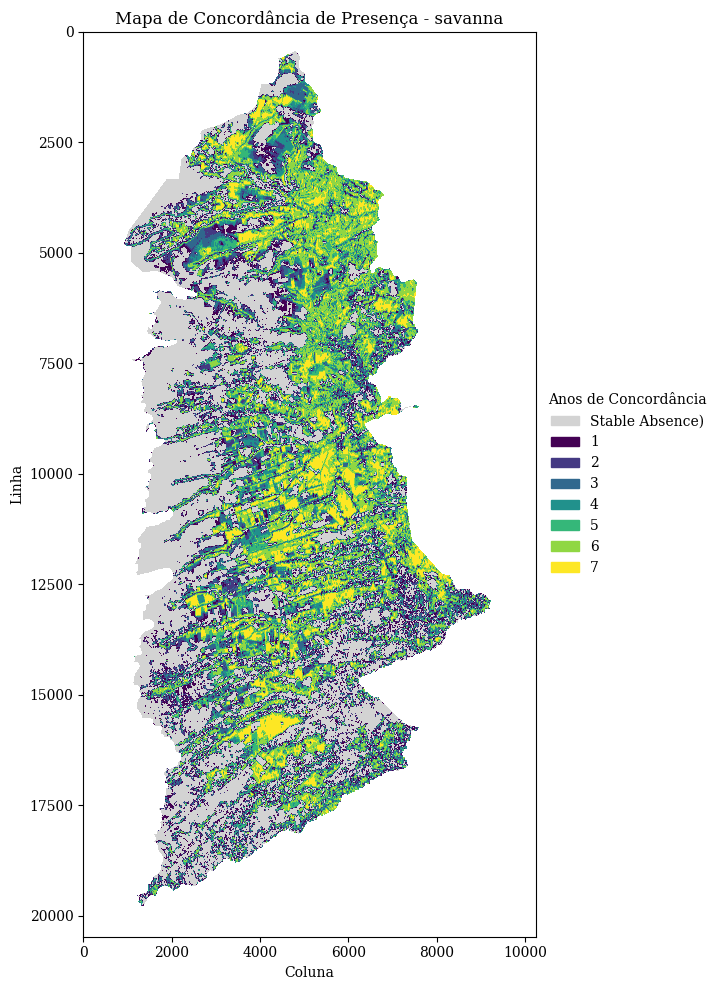

In [4]:
# =============================================================================
# NOVA CÉLULA: Mapa de Concordância de Presença Acumulada (An) - Versão Final
# =============================================================================
print("✅ Iniciando a Célula de Geração de Mapa de Concordância de Presença (An).")

# Importa as bibliotecas necessárias para a nova visualização
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

# =============================================================================
# 1. PREPARAÇÃO DO MAPA ACUMULADOR (Lógica inalterada)
# =============================================================================

first_year = time_points[0]
first_file_name = f"{class_name}{first_year}.tif"
path_to_first_file = os.path.join(path_series_x, first_file_name)

try:
    with rasterio.open(path_to_first_file) as src:
        profile = src.profile
        height, width = src.height, src.width
        An_map = np.zeros((height, width), dtype=np.float32)
        print(f"Mapa acumulador 'An' inicializado com dimensões: {height}x{width}.")
except FileNotFoundError:
    print(f"ERRO: Não foi possível encontrar o arquivo de referência '{path_to_first_file}' para inicializar o mapa.")
    An_map = None

# =============================================================================
# 2. CÁLCULO E ACUMULAÇÃO DOS HITS DE PRESENÇA (Lógica inalterada)
# =============================================================================

if An_map is not None:
    print("\nIniciando o cálculo pixel a pixel para cada ponto no tempo...")
    final_nodata_mask = np.ones_like(An_map, dtype=bool)

    for year in time_points:
        file_name = f"{class_name}{year}.tif"
        path_x = os.path.join(path_series_x, file_name)
        path_y = os.path.join(path_series_y, file_name)

        if os.path.exists(path_x) and os.path.exists(path_y):
            print(f"Processando: {file_name}...")
            with rasterio.open(path_x) as src_x, rasterio.open(path_y) as src_y:
                array_x = src_x.read(1)
                array_y = src_y.read(1)
                
                Phtn_map = np.minimum(array_x, array_y)
                valid_mask = (array_x != nodata_value) & (array_y != nodata_value)
                An_map[valid_mask] += Phtn_map[valid_mask]
                
                final_nodata_mask &= ~valid_mask
        else:
            print(f"Aviso: Arquivos para o ano {year} não encontrados. Pulando.")
            
    An_map[final_nodata_mask] = nodata_value

# =============================================================================
# 3. SALVAR E EXIBIR O MAPA FINAL (COM VISUALIZAÇÃO CORRIGIDA)
# =============================================================================

if An_map is not None:
    # --- Salvar o arquivo GeoTIFF ---
    profile.update(dtype=rasterio.float32, nodata=nodata_value)
    output_filename_map = f'map_An_presence_agreement_{class_name}.tif'
    print(f"\nSalvando o mapa final como: {output_filename_map}")
    with rasterio.open(output_filename_map, 'w', **profile) as dst:
        dst.write(An_map, 1)

    # --- Nova Lógica de Visualização Discreta e Individual ---
    print("Exibindo o mapa com legenda individual...")
    
    # 1. Mascara o array apenas para o valor de NoData
    masked_map = np.ma.masked_equal(An_map, nodata_value)

    # 2. Define as classes e cores para cada valor individual
    num_time_points = len(time_points)
    
    # Cria uma lista de cores: cinza para 0, e uma gama de 'viridis' para 1 a 7
    viridis_colors = plt.get_cmap('viridis', num_time_points)
    colors = ['lightgray'] + [viridis_colors(i / (num_time_points -1)) for i in range(num_time_points)]
    
    # Cria os limites para cada número. Ex: [0, 1, 2, ..., 8]
    boundaries = list(range(num_time_points + 2))
    
    # Cria o mapa de cores discreto
    cmap = ListedColormap(colors)
    # Define a cor para NoData como branco
    cmap.set_bad(color='white')
    
    # Normaliza os dados para que cada valor caia em sua cor/classe específica
    norm = BoundaryNorm(boundaries, cmap.N)
    
    # --- Plotagem ---
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(masked_map, cmap=cmap, norm=norm)
    
    ax.set_title(f'Mapa de Concordância de Presença - {class_name}')
    ax.set_xlabel('Coluna')
    ax.set_ylabel('Linha')

    # 4. Cria a legenda com uma "caixinha" para cada número
    labels_legenda = [f'Stable Absence)'] + [f'{i}' for i in range(1, num_time_points + 1)]
    patches = [mpatches.Patch(color=colors[i], label=labels_legenda[i]) for i in range(len(labels_legenda))]
    
    ax.legend(
        handles=patches,
        title='Anos de Concordância',
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        frameon=False
    )
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

## Presence Difference